# 1. Предобработка и разведочный анализ

Загружаем данные по покупками клиентов сети баров (файл "Обезличенные_данные_09_2019.xlsx") 
и файл "Справочник_блюд.xlsx" для присвоения категорий (групп) покупкам.

## Цель предобработки: получить дата-фрейм, в котором каждому клиенту соответствует одна строчка с информацией по столбцам.

* Проверяем наличие пропусков. В данных по покупкам есть строки с пропущенным значением "Пол", их удаляем.

* Дату переводим в нужный формат.

* Чтобы задать идентификатор каждого посещения бара, создаем колонку "Телефон и дата и бар" (это строковая сумма номера телефона (ID клиента), даты, номера бара).

* Объединяем данные по покупкам со Справочником блюд для присвоения блюдам категорий.

* Создаём дамми-переменные для дней недели (1-понедельник, 7- воскресенье).

* Методом группировки для каждого телеф.номера находим кол-во уникальных визитов (для этого используем созданную ранее колонку "Телефон и дата и бар") и общую сумму оплат за месяц (ARPU клиента).

* Добавляем к основному файлу эту информацию.

* Создаем колонки, соответствующие укрупненным категориям блюд, и проставляем количество заказанных блюд клиентом. С помощью группировки получаем таблицу, где по каждому клиенту вся информация в одной строчке.

* Добавляем дамми-переменные о дне недели, удаляем номер телефона (ID клиента), преобразуем "Пол" в бинарный тип (М-1, Ж-0).

* Готовый дата-фрейм экспортируем в файл "Data_Sept2019.xlsx".

* Визуализируем и интерпретируем существенные данные.

In [1]:
import pandas as pd
import time
from datetime import datetime
import re

In [2]:
data0=pd.read_excel('Обезличенные_данные_09_2019.xlsx')
Sprav=pd.read_excel('Справочник блюд.xlsx')

In [3]:
Sprav.head()

,Название товара,Группа,Группа укруп,Гр
0,STAFF РАФ кокосовый,Горячие напитки,Горячие напитки,Бар
1,3* Бифитер Пинк Тоник,Коктейли для друзей,Коктейли для друзей,Бар
2,3* Гордонс Пинк Лимонад,Коктейли для друзей,Коктейли для друзей,Бар
3,3*Бэллс Оридж. 40мл,Алк Сеты,Сеты,Бар
4,3*Капитан Кола,Алк Сеты,Сеты,Бар


In [4]:
Sprav.isnull().sum()

Название товара    0
Группа             0
Группа укруп       0
Гр                 0
dtype: int64

In [5]:
data0.head()

,Телефон,Пол,Дата покупки,Название товара,Количество,Бар,Оплачено
0,0,M,2019-09-08,3*Зеленая фея,1.0,3,657.0
1,1,M,2019-09-05,Графин Науки,1.0,1,279.0
2,1,M,2019-09-05,Вызов судьбы!,1.0,1,0.0
3,1,M,2019-09-05,Мишка под радугой,1.0,1,309.0
4,1,M,2019-09-05,Зеленая фея,2.0,1,550.0


In [6]:
data0.shape

(138051, 7)

In [7]:
data0.isna().sum()

Телефон               0
Пол                4532
Дата покупки          0
Название товара       0
Количество            0
Бар                   0
Оплачено              0
dtype: int64

In [8]:
data0.columns

Index(['Телефон', 'Пол', 'Дата покупки', 'Название товара', 'Количество',
       'Бар', 'Оплачено'],
      dtype='object')

In [9]:
data0.dropna(subset=['Пол'],inplace=True)

In [10]:
data0['Дата покупки2']=data0['Дата покупки'].apply(lambda x: x.strftime( '%Y-%m-%d' ) if not(pd.isnull(x)) else x)

In [11]:
def Pokupka(row):
    return str(row['Телефон'])+str(row['Дата покупки2'])+str(row['Бар'])

In [12]:
data0['Тел и Дата и Бар']=data0.apply(Pokupka, axis=1)
data0.head()

,Телефон,Пол,Дата покупки,Название товара,Количество,Бар,Оплачено,Дата покупки2,Тел и Дата и Бар
0,0,M,2019-09-08,3*Зеленая фея,1.0,3,657.0,2019-09-08,02019-09-083
1,1,M,2019-09-05,Графин Науки,1.0,1,279.0,2019-09-05,12019-09-051
2,1,M,2019-09-05,Вызов судьбы!,1.0,1,0.0,2019-09-05,12019-09-051
3,1,M,2019-09-05,Мишка под радугой,1.0,1,309.0,2019-09-05,12019-09-051
4,1,M,2019-09-05,Зеленая фея,2.0,1,550.0,2019-09-05,12019-09-051


In [13]:
data0=data0.merge(Sprav, on='Название товара', how='left')
data0.tail()

,Телефон,Пол,Дата покупки,Название товара,Количество,Бар,Оплачено,Дата покупки2,Тел и Дата и Бар,Группа,Группа укруп,Гр
133514,16156,Ж,2019-09-30,Скибиди Упа-па-па,2.0,5,418.0,2019-09-30,161562019-09-305,Сеты,Сеты,Бар
133515,16156,Ж,2019-09-30,Вызов судьбы!,2.0,5,0.0,2019-09-30,161562019-09-305,Акция Кости судьбы,Акции,Бар
133516,16156,Ж,2019-09-30,3*Зомби,1.0,5,537.0,2019-09-30,161562019-09-305,Коктейли для друзей,Коктейли для друзей,Бар
133517,16156,Ж,2019-09-30,Московская красавица,2.0,5,318.0,2019-09-30,161562019-09-305,Лонги,Лонги,Бар
133518,16156,Ж,2019-09-30,Малина 404,2.0,5,358.0,2019-09-30,161562019-09-305,Лонги,Лонги,Бар


In [14]:
data0.columns

Index(['Телефон', 'Пол', 'Дата покупки', 'Название товара', 'Количество',
       'Бар', 'Оплачено', 'Дата покупки2', 'Тел и Дата и Бар', 'Группа',
       'Группа укруп', 'Гр'],
      dtype='object')

In [15]:
days=data0['Дата покупки2'].reset_index()
days['День недели']=days['Дата покупки2'].apply(lambda x: 1+(pd.to_datetime(x).dayofweek))
days.tail()

,index,Дата покупки2,День недели
133514,133514,2019-09-30,1
133515,133515,2019-09-30,1
133516,133516,2019-09-30,1
133517,133517,2019-09-30,1
133518,133518,2019-09-30,1


In [16]:
dow=pd.get_dummies(days['День недели'])
dow.columns=['1','2','3','4','5','6','7']
dow

,1,2,3,4,5,6,7
0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0
5,0,0,0,1,0,0,0
6,0,0,0,1,0,0,0
7,0,0,0,1,0,0,0
8,0,0,0,1,0,0,0
9,0,0,0,1,0,0,0


In [17]:
Tabl1=data0.groupby(['Телефон', 'Тел и Дата и Бар'])['Оплачено'].sum().reset_index()
Tabl1.tail()

,Телефон,Тел и Дата и Бар,Оплачено
22298,16152,161522019-09-123,1373.0
22299,16153,161532019-09-183,1702.0
22300,16154,161542019-09-305,1273.0
22301,16155,161552019-09-046,189.0
22302,16156,161562019-09-305,3075.0


In [18]:
Tabl2=Tabl1.groupby(['Телефон'])['Оплачено'].sum().reset_index()
Tabl2.tail()

,Телефон,Оплачено
15572,16152,1373.0
15573,16153,1702.0
15574,16154,1273.0
15575,16155,189.0
15576,16156,3075.0


In [19]:
Tabl3=Tabl1.groupby(['Телефон'])['Оплачено'].count().reset_index()
Tabl3.tail()

,Телефон,Оплачено
15572,16152,1
15573,16153,1
15574,16154,1
15575,16155,1
15576,16156,1


In [20]:
Svod1=Tabl2.merge(Tabl3, on='Телефон', how='inner')
Svod1.columns=['Телефон', 'ARPU','Посещений']
Svod1.tail()

,Телефон,ARPU,Посещений
15572,16152,1373.0,1
15573,16153,1702.0,1
15574,16154,1273.0,1
15575,16155,189.0,1
15576,16156,3075.0,1


In [21]:
data0=data0.merge(Svod1, on='Телефон', how='inner')
data0=pd.concat([data0, dow], axis=1)
data0.tail()

,Телефон,Пол,Дата покупки,Название товара,Количество,Бар,Оплачено,Дата покупки2,Тел и Дата и Бар,Группа,...,Гр,ARPU,Посещений,1,2,3,4,5,6,7
133514,16156,Ж,2019-09-30,Скибиди Упа-па-па,2.0,5,418.0,2019-09-30,161562019-09-305,Сеты,...,Бар,3075.0,1,1,0,0,0,0,0,0
133515,16156,Ж,2019-09-30,Вызов судьбы!,2.0,5,0.0,2019-09-30,161562019-09-305,Акция Кости судьбы,...,Бар,3075.0,1,1,0,0,0,0,0,0
133516,16156,Ж,2019-09-30,3*Зомби,1.0,5,537.0,2019-09-30,161562019-09-305,Коктейли для друзей,...,Бар,3075.0,1,1,0,0,0,0,0,0
133517,16156,Ж,2019-09-30,Московская красавица,2.0,5,318.0,2019-09-30,161562019-09-305,Лонги,...,Бар,3075.0,1,1,0,0,0,0,0,0
133518,16156,Ж,2019-09-30,Малина 404,2.0,5,358.0,2019-09-30,161562019-09-305,Лонги,...,Бар,3075.0,1,1,0,0,0,0,0,0


In [22]:
Tabl_day=data0.groupby(['Телефон', 'Тел и Дата и Бар'])['1','2','3','4','5','6','7'].mean().reset_index()
Tabl_day.tail()

,Телефон,Тел и Дата и Бар,1,2,3,4,5,6,7
22298,16152,161522019-09-123,0,0,0,1,0,0,0
22299,16153,161532019-09-183,0,0,1,0,0,0,0
22300,16154,161542019-09-305,1,0,0,0,0,0,0
22301,16155,161552019-09-046,0,0,1,0,0,0,0
22302,16156,161562019-09-305,1,0,0,0,0,0,0


In [23]:
Tabl_day2=Tabl_day.groupby(['Телефон'])['1','2','3','4','5','6','7'].sum().reset_index()
Tabl_day2.tail()

,Телефон,1,2,3,4,5,6,7
15572,16152,0,0,0,1,0,0,0
15573,16153,0,0,1,0,0,0,0
15574,16154,1,0,0,0,0,0,0
15575,16155,0,0,1,0,0,0,0
15576,16156,1,0,0,0,0,0,0


In [24]:
#Формируем краткий файл на основе data0
df=data0.groupby(['Телефон', 'Пол', 'ARPU','Посещений', 'Группа укруп'])['Количество'].sum().reset_index()
df.tail()

,Телефон,Пол,ARPU,Посещений,Группа укруп,Количество
74441,16156,Ж,3075.0,1,Лонги,6.0
74442,16156,Ж,3075.0,1,Напитки TO GO,2.0
74443,16156,Ж,3075.0,1,Пицца,1.0
74444,16156,Ж,3075.0,1,Сеты,2.0
74445,16156,Ж,3075.0,1,"Соусы, хлеб",1.0


In [25]:
Group_Global=df['Группа укруп'].unique()
Group_Global

array(['Коктейли для друзей', 'Акции', 'Лонги', 'Пиво для друзей',
       'Пиво до 1л', 'Сеты', 'Наборы на компанию', 'Горячие блюда',
       'Горячие напитки', 'Кальяны', 'Снэки', 'Соусы, хлеб',
       'Холодные напитки', 'Крепкий алкоголь', 'Роллы', 'Пицца', 'Супы',
       'Стритфуд', 'Десерты', 'Салаты', 'Вино 125 мл', 'Вино', 'Прочее',
       'Напитки TO GO', 'Бизнес-ланч'], dtype=object)

In [26]:
def find_cuis(cell):
    if re.search(pattern, cell['Группа укруп']):
        return cell['Количество']
    else:
        return 0

In [27]:
for pattern in Group_Global:
    df[pattern]=df.apply(find_cuis, axis = 1)

In [28]:
df.tail()

,Телефон,Пол,ARPU,Посещений,Группа укруп,Количество,Коктейли для друзей,Акции,Лонги,Пиво для друзей,...,Пицца,Супы,Стритфуд,Десерты,Салаты,Вино 125 мл,Вино,Прочее,Напитки TO GO,Бизнес-ланч
74441,16156,Ж,3075.0,1,Лонги,6.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74442,16156,Ж,3075.0,1,Напитки TO GO,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
74443,16156,Ж,3075.0,1,Пицца,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74444,16156,Ж,3075.0,1,Сеты,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74445,16156,Ж,3075.0,1,"Соусы, хлеб",1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df2=df.groupby(['Телефон', 'Пол', 'ARPU','Посещений'])[Group_Global].sum().reset_index()
df2.tail()

,Телефон,Пол,ARPU,Посещений,Коктейли для друзей,Акции,Лонги,Пиво для друзей,Пиво до 1л,Сеты,...,Пицца,Супы,Стритфуд,Десерты,Салаты,Вино 125 мл,Вино,Прочее,Напитки TO GO,Бизнес-ланч
15572,16152,Ж,1373.0,1,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
15573,16153,M,1702.0,1,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
15574,16154,Ж,1273.0,1,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15575,16155,M,189.0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15576,16156,Ж,3075.0,1,1.0,3.0,6.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [30]:
data0['Телефон'].nunique()==len(df2)

True

In [31]:
len(Tabl_day2)==len(df2)

True

In [32]:
df2=df2.merge(Tabl_day2, on='Телефон', how='inner')
df2.tail()

,Телефон,Пол,ARPU,Посещений,Коктейли для друзей,Акции,Лонги,Пиво для друзей,Пиво до 1л,Сеты,...,Прочее,Напитки TO GO,Бизнес-ланч,1,2,3,4,5,6,7
15572,16152,Ж,1373.0,1,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,1,0,0,0
15573,16153,M,1702.0,1,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0,0,1,0,0,0,0
15574,16154,Ж,1273.0,1,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
15575,16155,M,189.0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,1,0,0,0,0
15576,16156,Ж,3075.0,1,1.0,3.0,6.0,0.0,0.0,2.0,...,0.0,2.0,0.0,1,0,0,0,0,0,0


In [33]:
df3 = df2.drop('Телефон', axis='columns')
df3['Пол'] = (df3['Пол']!='Ж').astype('int32')

In [34]:
with pd.ExcelWriter('Data_Sept2019.xlsx') as writer:  # doctest: +SKIP
    df3.to_excel(writer, sheet_name='data', index=False)

## Визуализация данных и разведочный анализ

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [36]:
df3.shape

(15577, 35)

In [37]:
df3.dtypes

Пол                      int32
ARPU                   float64
Посещений                int64
Коктейли для друзей    float64
Акции                  float64
Лонги                  float64
Пиво для друзей        float64
Пиво до 1л             float64
Сеты                   float64
Наборы на компанию     float64
Горячие блюда          float64
Горячие напитки        float64
Кальяны                float64
Снэки                  float64
Соусы, хлеб            float64
Холодные напитки       float64
Крепкий алкоголь       float64
Роллы                  float64
Пицца                  float64
Супы                   float64
Стритфуд               float64
Десерты                float64
Салаты                 float64
Вино 125 мл            float64
Вино                   float64
Прочее                 float64
Напитки TO GO          float64
Бизнес-ланч            float64
1                        uint8
2                        uint8
3                        uint8
4                        uint8
5       

In [38]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
Пол,15577.0,0.514605,0.499803,0.0,0.0,1.0,1.0,1.0
ARPU,15577.0,2722.421632,2703.512563,58.0,1052.0,1889.0,3439.0,49016.0
Посещений,15577.0,1.431790,1.040147,1.0,1.0,1.0,2.0,28.0
Коктейли для друзей,15577.0,0.669962,1.585240,0.0,0.0,0.0,1.0,22.0
Акции,15577.0,0.616165,1.556916,0.0,0.0,0.0,0.0,31.0
Лонги,15577.0,1.373178,2.551671,0.0,0.0,0.0,2.0,49.0
Пиво для друзей,15577.0,0.635809,1.399908,0.0,0.0,0.0,1.0,29.0
Пиво до 1л,15577.0,2.266033,3.655100,0.0,0.0,1.0,3.0,79.0
Сеты,15577.0,1.874366,3.528091,0.0,0.0,0.0,2.0,60.0
Наборы на компанию,15577.0,0.615972,0.931416,0.0,0.0,0.0,1.0,15.0


### Рассмотрим распределение признаков:
* размах ARPU от 58 руб. (минимум) до 49016 руб. (максимум) с медианным значением 1889 руб. (которое существенно отличается от среднего - 2722 руб. Это свидетельствует, что распределение не является нормальным).


* В перый квартиль не попала ни одна из категорий блюд и напитков (в силу особенностей продаж - наборами). 


* Во втором квартиле видим "Пиво до 1л" (1 порция). Это означает, что половина клиентов покупала менее 1 порции данного продукта, а половина - более 1 порции.


* В третий квартиль (верхние 25%) попали следующие категории: 1 "Коктейль для друзей" (где 3 порции), 2 лонга (=коктейля), 1 "Пиво для друзей" (3 порции), 3 "Пива до 1л.", 2 сета (алкогольных). Из блюд: 1 "Набор на компанию", 1 Горячее блюдо, 1 Снэк. Посещения: 1 в календарную субботу и 1 в календарное воскресенье, всего - 2 посещения.

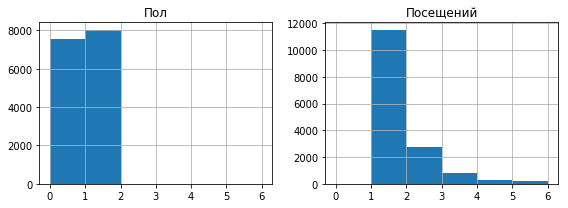

In [39]:
df3[['Пол','Посещений']].hist(figsize=(8, 3), bins=[0, 1, 2, 3, 4, 5, 6]);
plt.tight_layout()

* Видим, что девушек среди посетителей несколько меньше, чем парней (7561 против 8016).
* Больше всего клиентов посещают бар 1 раз за текущий месяц, далее с большим отрывом следуют 2, 3  посещения в месяц.

In [40]:
list=['Пол', 'Посещений']
for i in list:
    print(df3[i].value_counts())
    print('\n')

1    8016
0    7561
Name: Пол, dtype: int64


1     11492
2      2741
3       794
4       282
5       107
6        67
7        41
9        13
8        13
10        6
11        5
13        4
12        2
21        2
14        2
15        2
20        1
28        1
18        1
17        1
Name: Посещений, dtype: int64




### Посмотрим на ключевой признак - ARPU (доходность клиента за 1 месяц)

Text(0.5, 0, 'ARPU, руб.')

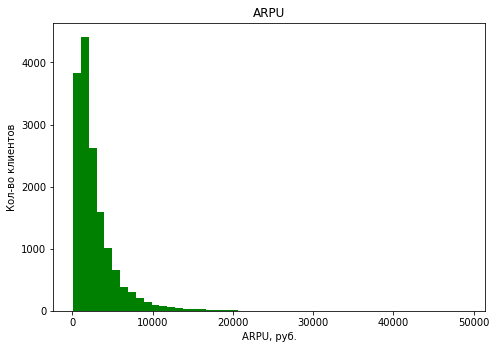

In [41]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df3['ARPU'], bins=50, color = 'green')
axes.set_title('ARPU')
axes.set_ylabel('Кол-во клиентов')
axes.set_xlabel('ARPU, руб.')

Text(0.5, 0, 'ARPU, руб.')

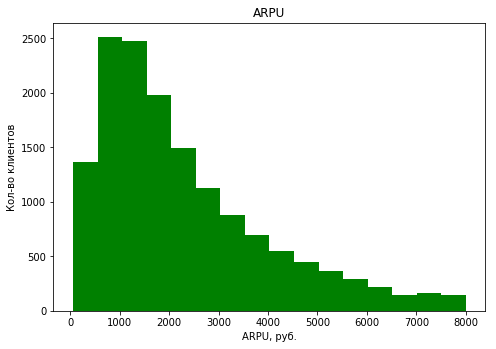

In [42]:
df4=df3[df3['ARPU']<8000]
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df4['ARPU'], bins=16, color = 'green')
axes.set_title('ARPU')
axes.set_ylabel('Кол-во клиентов')
axes.set_xlabel('ARPU, руб.')

* Построено 2 гистограммы по доходности клиентов (ARPU): общая и более подробная для ARPU < 8000 руб (с шагом 500р): предварительно видим, что больше всего клиентов тратят за месяц сумму в диапазоне 500-2000 руб. При этом точное медианное значение составляет 1889 руб.



### Построим диаграммы рассеяния для ARPU и всех остальных признаков:

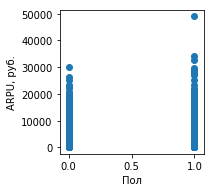

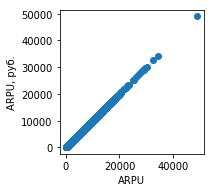

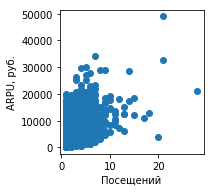

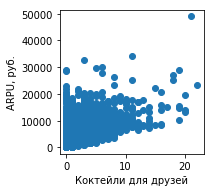

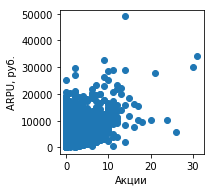

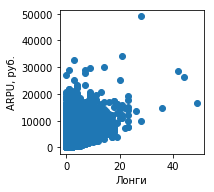

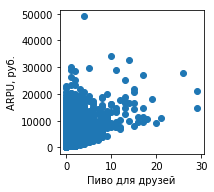

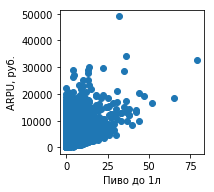

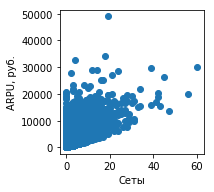

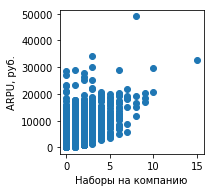

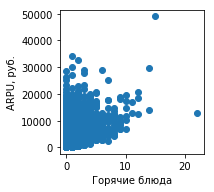

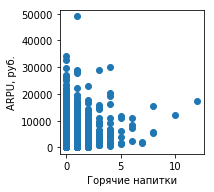

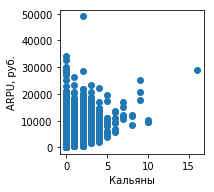

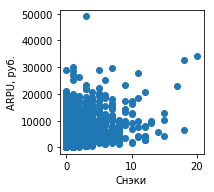

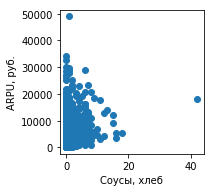

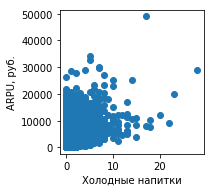

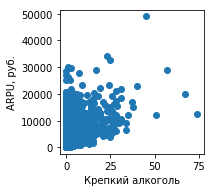

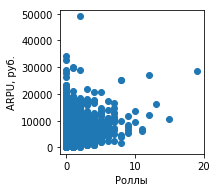

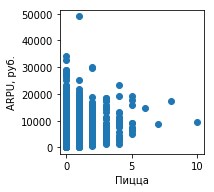

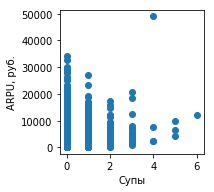

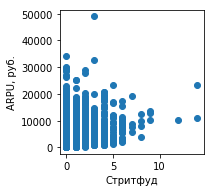

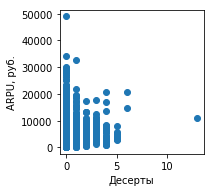

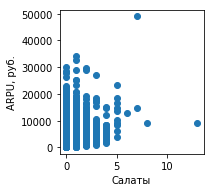

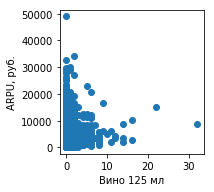

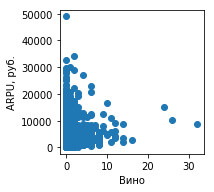

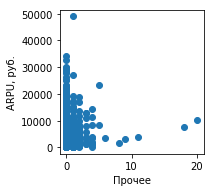

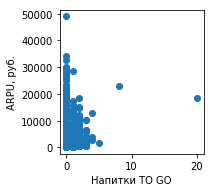

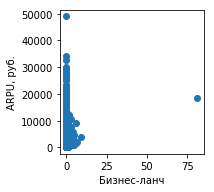

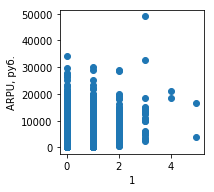

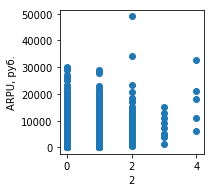

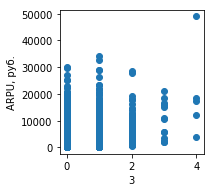

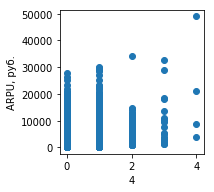

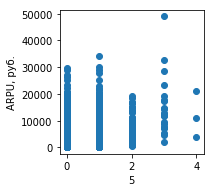

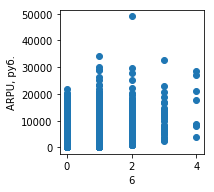

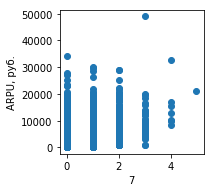

In [43]:
for col in df3.columns:
    
    fig = plt.figure(figsize=(2,2))
    axes = fig.add_axes([0, 0, 1, 1])
    axes.scatter(x=df3[col], y=df3['ARPU'], marker='o')
    axes.set_ylabel('ARPU, руб.')
    axes.set_xlabel(col)    

* Диаграммы рассеяния показывает, что высокое ARPU может быть при разном количестве посещений: начиная от 1 посещения.


### Посторим корреляционную матрицу

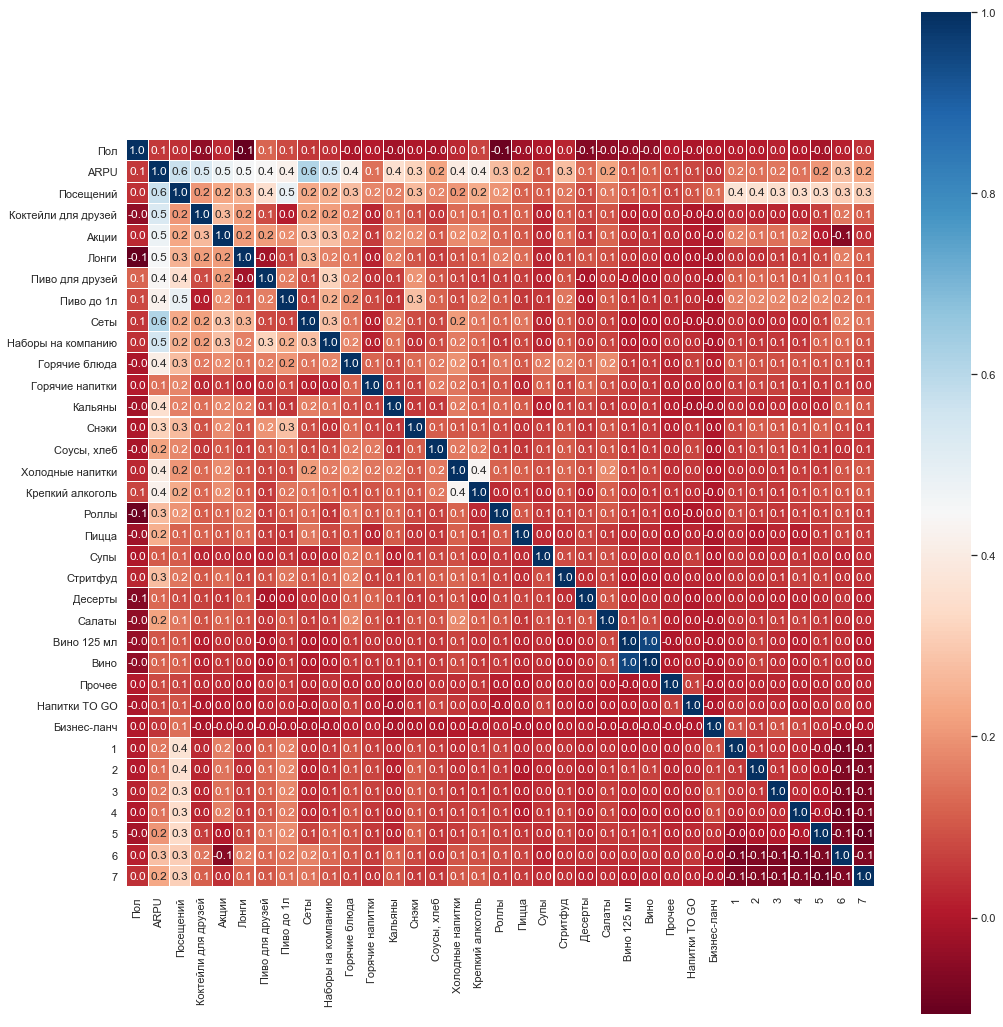

In [44]:
sns.set(font_scale=1)
plt.subplots(figsize=(15, 15))
sns.heatmap(df3.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()
plt.savefig('car_corr.png')

### Рассмотрим полученную корреляционную матрицу:

* ARPU имеет среднюю корреляцию со следующими признаками: кол-во посещений, заказ сетов (алкогольных наборов), "Коктейлей для друзей" (3шт), Акций, Лонгов (=коктейлей), Наборов на компанию (блюдо), а также положительно коррелирует с "Пиво до 1л", "Пиво для друзей", Крепкий алкоголь, Холодные напитки, Горячие блюда, Кальяны.


* Также видим корреляцию при заказе Крепких напитков и Холодных напитков, а также корреляцию "Вина 125мл" (по бокалам) и Вина в бутылках.